# Modular U-Net Example Notebook

This notebook demonstrates how parts of the `virtual_stain_flow.models` module
work independently and are organized together to form a working image-image
translation `torch.nn.Module` model.

## Dependencies

In [1]:
import yaml
import pathlib

import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Dataset
from virtual_stain_flow.datasets.PatchDataset import PatchDataset

## Model parts
from virtual_stain_flow.models.blocks import (
    Conv2DConvNeXtBlock,
    Conv2DNormActBlock
)
from virtual_stain_flow.models.up_down_blocks import (
    IdentityBlock,
    Conv2DDownBlock,
    MaxPool2DDownBlock,
    ConvTrans2DUpBlock,
    PixelShuffle2DUpBlock
)
from virtual_stain_flow.models.stages import Stage
from virtual_stain_flow.models.encoder import Encoder
from virtual_stain_flow.models.decoder import Decoder
from virtual_stain_flow.models.unet import UNet
from virtual_stain_flow.models.unext import ConvNeXtUNet

/home/weishanli/anaconda3/envs/cp_gan_viscy_env/lib/python3.9/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Retrieve Demo Data

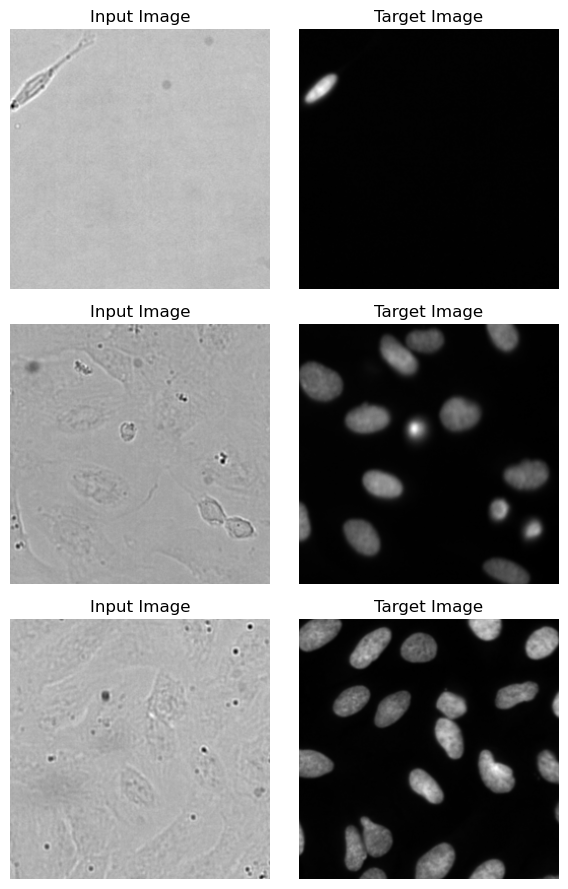

In [2]:
ANALYSIS_REPO_ROOT = pathlib.Path('.').absolute().parent / 'pediatric_cancer_atlas_analysis'
CONFIG_PATH = ANALYSIS_REPO_ROOT / 'config.yml'
config = yaml.safe_load(CONFIG_PATH.read_text())

LOADDATA_FILE_PATH = ANALYSIS_REPO_ROOT / '0.data_preprocessing' / 'data_split_loaddata' / 'loaddata_train.csv'
PROFILING_DIR = pathlib.Path(config['paths']['pediatric_cancer_atlas_profiling_path'])
SC_FEATURES_DIR = pathlib.Path(config['paths']['sc_features_path'])

for path in [ANALYSIS_REPO_ROOT, CONFIG_PATH, LOADDATA_FILE_PATH]:
    assert path.exists(), f"File/Directory not found: {PROFILING_DIR}"

# subset the loaddata_df to 100 samples for faster example run
loaddata_df = pd.read_csv(LOADDATA_FILE_PATH)
loaddata_df = loaddata_df.sample(n=100, random_state=42)

sc_features = pd.DataFrame()
for plate in loaddata_df['Metadata_Plate'].unique():
    sc_features_parquet = SC_FEATURES_DIR / f'{plate}_sc_normalized.parquet'
    if not sc_features_parquet.exists():
        print(f'{sc_features_parquet} does not exist, skipping...')
        continue 
    else:
        sc_features = pd.concat([
            sc_features, 
            pd.read_parquet(
                sc_features_parquet,
                columns=['Metadata_Plate', 'Metadata_Well', 'Metadata_Site', 'Metadata_Cells_Location_Center_X', 'Metadata_Cells_Location_Center_Y']
            )
        ])

INPUT_CHANNEL_NAMES = config['data']['input_channel_keys']
TARGET_CHANNEL_NAMES = config['data']['target_channel_keys']
PATCH_SIZE = 256

pds = PatchDataset(
        _loaddata_csv=loaddata_df,
        _sc_feature=sc_features,
        _input_channel_keys=INPUT_CHANNEL_NAMES,
        _target_channel_keys=TARGET_CHANNEL_NAMES,
        _input_transform=None,
        _target_transform=None,
        patch_size=PATCH_SIZE,
        verbose=False,
        patch_generation_method="random_cell",
        n_expected_patches_per_img=50,
        patch_generation_random_seed=42
    )

panel_width = 3
indices = [3, 5, 7]
fig, ax = plt.subplots(len(indices), 2, figsize=(panel_width * 2, panel_width * len(indices)))

for i, j in enumerate(indices):

    input, target = pds[j]
    ax[i][0].imshow(input[0], cmap='gray')
    ax[i][0].set_title('Input Image')
    ax[i][0].axis('off')
    ax[i][1].imshow(target[0], cmap='gray')
    ax[i][1].set_title('Target Image')
    ax[i][1].axis('off')
plt.tight_layout()
plt.show()

## Apply a 1×1 Convolution to Expand Input Channels

In this step, we simulate the common practice in U-Net architectures of increasing the channel dimension at the very beginning of the network.  
A 1×1 convolutional layer with a relatively large number of filters (e.g., 32 or 64) is applied to the input image tensor `(B, C, H, W)`, where `C` is typically small (1 for grayscale or 3 for RGB images).  

This operation transforms the input into a richer feature representation by producing many output channels. Each filter is expected to learn different spatial patterns, which are then propagated through the rest of the network.

In [3]:
input, _ = pds[0]
input_tensor = input.unsqueeze(0)  # Add batch dimension
print(f"Input tensor shape: {input_tensor.shape}")

# up-sample input image tensor to have a higher channel
# count prior to entring the first convolutional blocks.
base_channels = 64
conv_more = nn.Conv2d(
    in_channels=input_tensor.shape[1],
    out_channels=base_channels,
    kernel_size=1, # 1x1 convolution, no spatial context is learned here
    stride=1,
    padding=0
)
input_up_tensor = conv_more(input_tensor)

# note that the spatial dimensions remain the same here
print(f"Input tensor after up-convolution shape: {input_up_tensor.shape}")

Input tensor shape: torch.Size([1, 1, 256, 256])
Input tensor after up-convolution shape: torch.Size([1, 64, 256, 256])


## Compute Blocks
Compute blocks are spatially preserving units that extract features from the 
image at each resolution level of the network. 
They are typically placed **after each downsampling step** to refine the 
feature maps without changing their spatial dimensions.

These blocks are commonly implemented using convolutional layers with:
- Kernel sizes larger than 1 (often 3×3),
- Stride of 1,
- `"same"` padding.

Using a larger kernel size increases the receptive field, enabling the model 
to capture more contextual information, though at the cost of additional computation.

### Conventional Conv2D>BatchNorm>ReLU Compute Block

The most common form of compute blocks found in UNets,
consisting of 2 repeats of Conv2D, BatchNorm and ReLu.

In [4]:
num_units = 2  # most UNets use 2 repeated Conv2DBatchNormReLUs
conv_bn_relu = Conv2DNormActBlock(
    in_channels=base_channels,
    out_channels=base_channels, # same number of channels
    num_units=num_units,
    norm_type='batch',
    act_type='relu'
)
print(f"Architecture of a {num_units} unit Conv2DBatchNormReLU Block: \n" + 
      str(conv_bn_relu) + '\n')

print(f"Input tensor before Conv2DBatchNormReLU Block shape: {input_up_tensor.shape}")
_ = conv_bn_relu(input_up_tensor)
# note that both the spatial dimensions and the number of channels remain the same
print(f"Input tensor after Conv2DBatchNormReLU Block shape: {_.shape}")

Architecture of a 2 unit Conv2DBatchNormReLU Block: 
Conv2DNormActBlock(
  (network): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
)

Input tensor before Conv2DBatchNormReLU Block shape: torch.Size([1, 64, 256, 256])
Input tensor after Conv2DBatchNormReLU Block shape: torch.Size([1, 64, 256, 256])


### ConvNeXt Compute Block
A more modern architecture for compute introduced by Liu et. al. 2022,
"A ConvNet for the 2020s". Based on a ResNet architecture.  

Note here that when `in_channels == out_channels`, no leading Conv2D or Normalization
layer will be added to the ConvNeXt block.

In [5]:
num_units = 1
convnext_block = Conv2DConvNeXtBlock(
    in_channels=base_channels,
    out_channels=base_channels, # same number of channels
    num_units=num_units,
    norm_type='layer',
    convnext_kernel_size=7 # sets the ConvNeXt depthwise convolution kernel size
)

print(f"Architecture of a {num_units} unit Conv2DConvNeXt Block: \n" + 
      str(convnext_block) + '\n')

Architecture of a 1 unit Conv2DConvNeXt Block: 
Conv2DConvNeXtBlock(
  (network): Sequential(
    (0): ConvNeXtBlock(
      (conv_dw): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
      (norm): LayerNorm2d((64,), eps=1e-06, elementwise_affine=True)
      (mlp): GlobalResponseNormMlp(
        (fc1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (grn): GlobalResponseNorm()
        (fc2): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (shortcut): Identity()
      (drop_path): Identity()
    )
  )
)



Now observe that the Conv2DConvNeXtBlock has a leading Conv2D layer
and a leading Normalization layer to adjust the number of channels

In [6]:
num_units = 1
convnext_block2 = Conv2DConvNeXtBlock(
    in_channels=base_channels,
    out_channels=base_channels * 2, # double the number of channels
    num_units=num_units,
    norm_type='layer',
    conv_kernel_size=1, # sets leading Conv2D kernel size
    convnext_kernel_size=7 # sets the ConvNeXt depthwise convolution kernel size
)

print(f"Architecture of a {num_units} unit Conv2DConvNeXt Block with leading Conv2D: \n" + 
      str(convnext_block2) + '\n')

Architecture of a 1 unit Conv2DConvNeXt Block with leading Conv2D: 
Conv2DConvNeXtBlock(
  (network): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): GroupNorm(1, 128, eps=1e-05, affine=True)
    (2): ConvNeXtBlock(
      (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
      (norm): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      (mlp): GlobalResponseNormMlp(
        (fc1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (grn): GlobalResponseNorm()
        (fc2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (shortcut): Identity()
      (drop_path): Identity()
    )
  )
)



In [7]:
print(f"Input tensor before Conv2DConvNeXt Block shape: {input_up_tensor.shape}")
_ = convnext_block2(input_up_tensor)
# note that the spatial dimensions remain the same, but the number of channels has doubled
print(f"Input tensor after Conv2DConvNeXt Block shape: {_.shape}")

Input tensor before Conv2DConvNeXt Block shape: torch.Size([1, 64, 256, 256])
Input tensor after Conv2DConvNeXt Block shape: torch.Size([1, 128, 256, 256])


## (Spatial) Down-sampling Blocks

Down-sampling blocks reduce the spatial resolution of feature maps while
typically increasing the number of channels. This step allows the model
to capture increasingly abstract and large-scale features as the network
goes deeper.  

Common approaches to down-sampling include:
- **Max pooling:** A non-learnable operation that keeps the most prominent
  feature in a local window.
- **Strided convolutions:** A learnable alternative where the convolution
  operation itself uses a stride > 1 to reduce spatial size.

Reducing spatial dimensions helps the network expand its receptive field,
aggregate context, and reduce computational load in deeper layers.

### No-op identity block
Meant for the first layer of UNet because we might not want to down-sample the
image before doing any compute.

In [8]:
identity_block = IdentityBlock(
    in_channels=base_channels
)
# IdentityBlock is a no-op block that does not change the input tensor.
print(f"Architecture of IdentityBlock: \n" + 
      str(identity_block) + '\n')

print(f"Input tensor before IdentityBlock shape: {input_up_tensor.shape}")
_ = identity_block(input_up_tensor)
print(f"Input tensor after IdentityBlock shape: {_.shape}")

Architecture of IdentityBlock: 
IdentityBlock(
  (network): Identity()
  (activation): Identity()
)

Input tensor before IdentityBlock shape: torch.Size([1, 64, 256, 256])
Input tensor after IdentityBlock shape: torch.Size([1, 64, 256, 256])


### Classic Conv2D based downsampling Block

The Conv2DDownBlock implementation has a fixed Conv2D 
with kernel size 2 and stride 2, achieveing a scaling by a factor of **2**

By default the spatial dimensions are halved, and the number of channels are doubled

In [9]:
conv_down_block = Conv2DDownBlock(
    in_channels=base_channels,
    out_channels=None # by default doubles the number of channels
)

print(f"Architecture of Conv2DDownBlock: \n" + 
      str(conv_down_block) + '\n')

print(f"Input tensor before Conv2DDownBlock shape: {input_up_tensor.shape}")
_ = conv_down_block(input_up_tensor)

print(f"Input tensor after Conv2DDownBlock shape: {_.shape}")

Architecture of Conv2DDownBlock: 
Conv2DDownBlock(
  (network): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (activation): Identity()
)

Input tensor before Conv2DDownBlock shape: torch.Size([1, 64, 256, 256])
Input tensor after Conv2DDownBlock shape: torch.Size([1, 128, 128, 128])


#### Conv2DDownBlock can optionally be followed by a Normalization layer. 

In [10]:
conv_down_block_norm = Conv2DDownBlock(
    in_channels=base_channels,
    out_channels=None, 
    norm_type='batch',
)
print(f"Architecture of Conv2DDownBlock with BatchNorm: \n" +
      str(conv_down_block_norm) + '\n')

Architecture of Conv2DDownBlock with BatchNorm: 
Conv2DDownBlock(
  (network): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
  (activation): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)



### Non-learnable MaxPool2DDownBlock

The spatial dimensions are halved, but the number of channels remains the same

In [11]:
maxpool_down_block = MaxPool2DDownBlock(
    in_channels=base_channels,
    out_channels=None # maxpooling does not (and cannot) change the number of channels
)
print(f"Architecture of MaxPool2DDownBlock: \n" + 
      str(maxpool_down_block) + '\n')

print(f"Input tensor before MaxPool2DDownBlock shape: {input_up_tensor.shape}")
_ = maxpool_down_block(input_up_tensor)

print(f"Input tensor after MaxPool2DDownBlock shape: {_.shape}")

Architecture of MaxPool2DDownBlock: 
MaxPool2DDownBlock(
  (network): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Input tensor before MaxPool2DDownBlock shape: torch.Size([1, 64, 256, 256])
Input tensor after MaxPool2DDownBlock shape: torch.Size([1, 64, 128, 128])


## Behavior of (Spatial) Up-sampling Blocks

Up-sampling blocks perform the reverse operation: they increase the spatial
resolution of feature maps as the network moves back toward the output.
These blocks gradually reconstruct fine-grained details and often make use
of skip connections from the down-sampling path to recover lost spatial
information.

Common approaches to up-sampling include:
- **Transposed convolutions (deconvolutions):** Learnable filters that
  expand feature maps.
- **Upsample + convolution:** A two-step process where the feature map is
  resized (e.g., nearest neighbor or bilinear interpolation) and then refined
  with a convolution.
- **Pixel shuffle:** A reorganization of channels into spatial dimensions
  (less common but useful in some architectures).

### Tranposed Convoltuion based up Block
ConvTrans2DUpBlock uses a ConvTranspose2D layer to upsample the input tensor.

In [12]:
convt_up_block = ConvTrans2DUpBlock(
    in_channels=base_channels,
    out_channels=None,  # by default halves the number of channels
)

print(f"Architecture of ConvTrans2DUpBlock: \n" + 
      str(convt_up_block) + '\n')

print(f"Input tensor before ConvTrans2DUpBlock shape: {input_up_tensor.shape}")
_ = convt_up_block(input_up_tensor)
print(f"Input tensor after ConvTrans2DUpBlock shape: {_.shape}")

Architecture of ConvTrans2DUpBlock: 
ConvTrans2DUpBlock(
  (network): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (activation): Identity()
)

Input tensor before ConvTrans2DUpBlock shape: torch.Size([1, 64, 256, 256])
Input tensor after ConvTrans2DUpBlock shape: torch.Size([1, 32, 512, 512])


#### ConvTrans2DUpBlock can optionally be followed by a Normalization layer, too. 

In [13]:
convt_up_block_norm = ConvTrans2DUpBlock(
    in_channels=base_channels,
    out_channels=None,  # by default halves the number of channels
    norm_type='batch'
)
print(f"Architecture of ConvTrans2DUpBlock with BatchNorm: \n" +
      str(convt_up_block_norm) + '\n')

Architecture of ConvTrans2DUpBlock with BatchNorm: 
ConvTrans2DUpBlock(
  (network): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (activation): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)



### Non-learnable, "sub-pixel" resoltuion PixelShuffle2DUpBlock

PixelShuffle2DUpBlock is a monai SubpixelUpsample under the hood,
which contains a leading Conv2D layer to adjust the number of channels
and a PixelShuffle layer to upsample the spatial dimensions.

See that the spatial dimensions are doubled, and the number of channels decrease by
a factor of 4 (2 per spatial dimension ^ 2 spatial dimensions)

In [14]:
pixel_shuffle_up_block = PixelShuffle2DUpBlock(
    in_channels=base_channels,
    out_channels=None,  # by default halves the number of channels
)

print(f"Architecture of PixelShuffle2DUpBlock: \n" + 
      str(pixel_shuffle_up_block) + '\n')
print(f"Input tensor before PixelShuffle2DUpBlock shape: {input_up_tensor.shape}")
_ = pixel_shuffle_up_block(input_up_tensor)

print(f"Input tensor after PixelShuffle2DUpBlock shape: {_.shape}")

Architecture of PixelShuffle2DUpBlock: 
PixelShuffle2DUpBlock(
  (network): SubpixelUpsample(
    (conv_block): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pad_pool): Sequential(
      (0): ConstantPad2d(padding=(1, 0, 1, 0), value=0.0)
      (1): AvgPool2d(kernel_size=2, stride=1, padding=0)
    )
  )
)

Input tensor before PixelShuffle2DUpBlock shape: torch.Size([1, 64, 256, 256])
Input tensor after PixelShuffle2DUpBlock shape: torch.Size([1, 16, 512, 512])


## Initialization and behavior of Stages
Stage is a level of abstraction that we define to organize down/up sampling
blocks and compute blocks together. 

### Standard fully convolutional UNet down stage composed of a Conv2D down block and a ConvBatchNormReLu compute block with 2 units

see that the spatial dimensions are halved, and the number of channels is doubled

In [15]:
unet_down_stage = Stage(
    in_channels=base_channels,
    out_channels=base_channels * 2,
    in_block_handle=Conv2DDownBlock,
    in_block_kwargs={'norm_type': 'batch'},
    comp_block_handle=Conv2DNormActBlock,
    comp_block_kwargs={'num_units': 2, 'norm_type': 'batch', 'act_type': 'relu'}
)
print(f"Architecture of UNet Down Stage: \n" + 
      str(unet_down_stage) + '\n')

print(f"Input tensor before UNet Down Stage shape: {input_up_tensor.shape}")
_ = unet_down_stage(input_up_tensor)

print(f"Input tensor after UNet Down Stage shape: {_.shape}")

Architecture of UNet Down Stage: 
Stage(
  (in_block): Conv2DDownBlock(
    (network): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (activation): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (comp_block): Conv2DNormActBlock(
    (network): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
)

Input tensor before UNet Down Stage shape: torch.Size([1, 64, 256, 256])
Input tensor after UNet Down Stage shape: torch.Size([1, 128, 128, 128])


### UNet down stage with a Maxpooling down block and a ConvBatchNormReLu compute block with 2 units

see that unlike the Conv2DDownBlock, the MaxPool2DDownBlock does not change the number
of channels, and the first Conv2DNormActBlock in the stage compensates for that by
upsampling the number of channels from base_channels to base_channels * 2

In [16]:
unet_down_stage2 = Stage(
    in_channels=base_channels,
    out_channels=base_channels * 2,
    in_block_handle=MaxPool2DDownBlock,
    comp_block_handle=Conv2DNormActBlock,
    comp_block_kwargs={'num_units': 2, 'norm_type': 'batch', 'act_type': 'relu'}
)
print(f"Architecture of UNet Down Stage with MaxPool2DDownBlock: \n" + 
      str(unet_down_stage2) + '\n')

print(f"Input tensor before UNet Down Stage with MaxPool2DDownBlock shape: {input_up_tensor.shape}")
_ = unet_down_stage2(input_up_tensor)

print(f"Input tensor after UNet Down Stage with MaxPool2DDownBlock shape: {_.shape}")

Architecture of UNet Down Stage with MaxPool2DDownBlock: 
Stage(
  (in_block): MaxPool2DDownBlock(
    (network): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (comp_block): Conv2DNormActBlock(
    (network): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
)

Input tensor before UNet Down Stage with MaxPool2DDownBlock shape: torch.Size([1, 64, 256, 256])
Input tensor after UNet Down Stage with MaxPool2DDownBlock shape: torch.Size([1, 128, 128, 128])


### Constructing an fully convolution up-sampling stage that operates on a down stage output

In [17]:
unet_up_stage = Stage(
    in_channels=unet_down_stage2.out_channels, # the output channels of the previous down stage
    out_channels=unet_down_stage2.out_channels // 2, # halve the number of channels
    in_block_handle=ConvTrans2DUpBlock,
    in_block_kwargs={'norm_type': 'batch'},
    comp_block_handle=Conv2DNormActBlock,
    comp_block_kwargs={'num_units': 2, 'norm_type': 'batch', 'act_type': 'relu'}
)
print(f"Architecture of UNet Up Stage: \n" + 
      str(unet_up_stage) + '\n')

down_stage_output = unet_down_stage2(input_up_tensor)
print(f"Input tensor before UNet Up Stage shape: {down_stage_output.shape}")
_ = unet_up_stage(down_stage_output)
# see that the spatial dimensions are doubled, and the number of channels is halved
print(f"Input tensor after UNet Up Stage shape: {_.shape}")

Architecture of UNet Up Stage: 
Stage(
  (in_block): ConvTrans2DUpBlock(
    (network): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (activation): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (comp_block): Conv2DNormActBlock(
    (network): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
)

Input tensor before UNet Up Stage shape: torch.Size([1, 128, 128, 128])
Input tensor after UNet Up Stage shape: torch.Size([1, 64, 256, 256])


### PixelShuffle stage example

In [18]:
unet_up_stage2 = Stage(
    in_channels=unet_down_stage2.out_channels, # the output channels of the previous down stage
    out_channels=unet_down_stage2.out_channels // 2, # halve the number of channels
    in_block_handle=PixelShuffle2DUpBlock,
    comp_block_handle=Conv2DNormActBlock,
    comp_block_kwargs={'num_units': 2, 'norm_type': 'batch', 'act_type': 'relu'}
)
print(f"Architecture of UNet Up Stage with PixelShuffle2DUpBlock: \n" + 
      str(unet_up_stage2) + '\n')

print(f"Input tensor before UNet Up Stage with PixelShuffle2DUpBlock shape: {down_stage_output.shape}")
_ = unet_up_stage2(down_stage_output)
# see that the spatial dimensions are doubled, and the number of channels is halved
print(f"Input tensor after UNet Up Stage with PixelShuffle2DUpBlock shape: {_.shape}")

Architecture of UNet Up Stage with PixelShuffle2DUpBlock: 
Stage(
  (in_block): PixelShuffle2DUpBlock(
    (network): SubpixelUpsample(
      (conv_block): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pad_pool): Sequential(
        (0): ConstantPad2d(padding=(1, 0, 1, 0), value=0.0)
        (1): AvgPool2d(kernel_size=2, stride=1, padding=0)
      )
    )
  )
  (comp_block): Conv2DNormActBlock(
    (network): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
)

Input tensor before UNet Up Stage with PixelShuffle2DUpBlock shape: torch.Size([1, 128, 128, 128])
Input tensor after UNet Up Stage with Pixe

## Encoders and Decoders
They are essentially packaged sequence of multiple stages

### Fully convolutional UNet Encoder

In [19]:
unet_encoder = Encoder(
    in_channels=base_channels,
    in_block_handles = [
        IdentityBlock, # in the first stage we don't change the spatial dimensions
        Conv2DDownBlock, # from second stage onwards we halve the spatial dimensions
        Conv2DDownBlock,
        Conv2DDownBlock
    ],
    in_block_kwargs = {'norm_type': 'batch'},
    comp_block_handles=Conv2DNormActBlock, # use the same compute block for all stages
    comp_block_kwargs={'num_units': 2, 'norm_type': 'batch', 'act_type': 'relu'}
)
print(f"Architecture of UNet Encoder: \n" + 
      str(unet_encoder) + '\n')

Architecture of UNet Encoder: 
Encoder(
  (stages): ModuleList(
    (0): DownStage(
      (in_block): IdentityBlock(
        (network): Identity()
        (activation): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (comp_block): Conv2DNormActBlock(
        (network): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
    (1): DownStage(
      (in_block): Conv2DDownBlock(
        (network): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
        (activation): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [20]:
# the forward pass of a Encoder returns a list of down sampled feature maps
down_sample_feature_maps = unet_encoder(input_up_tensor)
# we specified 4 stages in the UNet Encoder, so we expect 4 feature maps
print(f"Number of feature maps from UNet Encoder forward pass: {len(down_sample_feature_maps)}")
# see down sampled feature maps have iteratively halved spatial dimensions
# and the number of channels is doubled at each stage
for i, feature_map in enumerate(down_sample_feature_maps):
    print(f"Feature map {i} shape: {feature_map.shape}")

Number of feature maps from UNet Encoder forward pass: 4
Feature map 0 shape: torch.Size([1, 128, 256, 256])
Feature map 1 shape: torch.Size([1, 256, 128, 128])
Feature map 2 shape: torch.Size([1, 512, 64, 64])
Feature map 3 shape: torch.Size([1, 1024, 32, 32])


### Maxpool UNet Encoder

In [21]:
unet_encoder2 = Encoder(
    in_channels=base_channels,
    in_block_handles = [
        IdentityBlock, # in the first stage we don't change the spatial dimensions
        MaxPool2DDownBlock, # just replace the Conv2DDownBlock with MaxPool2DDownBlock
        MaxPool2DDownBlock,
        MaxPool2DDownBlock
    ],
    comp_block_handles=Conv2DNormActBlock, # use the same compute block for all stages
    comp_block_kwargs={'num_units': 2, 'norm_type': 'batch', 'act_type': 'relu'}
)
print(f"Architecture of UNet Encoder with MaxPool2DDownBlock: \n" + 
      str(unet_encoder2) + '\n')

Architecture of UNet Encoder with MaxPool2DDownBlock: 
Encoder(
  (stages): ModuleList(
    (0): DownStage(
      (in_block): IdentityBlock(
        (network): Identity()
        (activation): Identity()
      )
      (comp_block): Conv2DNormActBlock(
        (network): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
    (1): DownStage(
      (in_block): MaxPool2DDownBlock(
        (network): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (comp_block): Conv2DNormActBlock(
        (network): Sequential(
          (0): Conv2d(128, 256, kernel_si

In [22]:
down_sample_feature_maps = unet_encoder2(input_up_tensor)
print(f"Number of feature maps from UNet Encoder with MaxPool2DDownBlock forward pass: {len(down_sample_feature_maps)}")
# see that the spatial dimensions are halved, but the number of channels remains the same
# because the MaxPool2DDownBlock does not change the number of channels
for i, feature_map in enumerate(down_sample_feature_maps):
    print(f"Feature map {i} shape: {feature_map.shape}")

Number of feature maps from UNet Encoder with MaxPool2DDownBlock forward pass: 4
Feature map 0 shape: torch.Size([1, 128, 256, 256])
Feature map 1 shape: torch.Size([1, 256, 128, 128])
Feature map 2 shape: torch.Size([1, 512, 64, 64])
Feature map 3 shape: torch.Size([1, 1024, 32, 32])


### Fully convolutional UNet Decoder accepting skip connections from the downsampling path

In [23]:
unet_decoder = Decoder(
    encoder_feature_map_channels=unet_encoder.feature_map_channels, # the output channels of the encoder
    in_block_handles=ConvTrans2DUpBlock, # use ConvTrans2DUpBlock for upsampling
    comp_block_handles=Conv2DNormActBlock, # use Conv2DNormActBlock for computation
    comp_block_kwargs={'num_units': 2, 'norm_type': 'batch', 'act_type': 'relu'}
)
print(f"Architecture of UNet Decoder: \n" + 
      str(unet_decoder) + '\n')

Architecture of UNet Decoder: 
Decoder(
  (stages): ModuleList(
    (0): UpStage(
      (in_block): ConvTrans2DUpBlock(
        (network): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
        (activation): Identity()
      )
      (comp_block): Conv2DNormActBlock(
        (network): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
    (1): UpStage(
      (in_block): ConvTrans2DUpBlock(
        (network): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
        (activation): Identity()
      )
      (comp_block): Conv2DNormActBlock(
        (network): Sequ

In [24]:
decoder_output = unet_decoder(down_sample_feature_maps)
# the output of the decoder should have the same spatial dimension as the input tensor
print(f"Decoder output shape: {decoder_output.shape}")

Decoder output shape: torch.Size([1, 128, 256, 256])


### PixelShuffle Decoder Example

In [25]:
pixel_shuffle_decoder = Decoder(
    encoder_feature_map_channels=unet_encoder.feature_map_channels, 
    in_block_handles=PixelShuffle2DUpBlock, # use PixelShuffle2DUpBlock for upsampling
    comp_block_handles=Conv2DConvNeXtBlock, # use Conv2DConvNeXtBlock for computation
    comp_block_kwargs={'num_units': 2}
)
print(f"Architecture of PixelShuffle Decoder: \n" + 
      str(pixel_shuffle_decoder) + '\n')

Architecture of PixelShuffle Decoder: 
Decoder(
  (stages): ModuleList(
    (0): UpStage(
      (in_block): PixelShuffle2DUpBlock(
        (network): SubpixelUpsample(
          (conv_block): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pad_pool): Sequential(
            (0): ConstantPad2d(padding=(1, 0, 1, 0), value=0.0)
            (1): AvgPool2d(kernel_size=2, stride=1, padding=0)
          )
        )
      )
      (comp_block): Conv2DConvNeXtBlock(
        (network): Sequential(
          (0): Conv2d(768, 512, kernel_size=(1, 1), stride=(1, 1), padding=same)
          (1): GroupNorm(1, 512, eps=1e-05, affine=True)
          (2): ConvNeXtBlock(
            (conv_dw): Conv2d(512, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=512)
            (norm): LayerNorm2d((512,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1))
            

In [26]:
decoder_output = unet_decoder(down_sample_feature_maps)
# the output of the decoder should have the same shape as the input tensor
print(f"Decoder output shape: {decoder_output.shape}")

Decoder output shape: torch.Size([1, 128, 256, 256])


## Decoder works with other convolutional model architectures!

In [27]:
import timm

# timm implementation of the depth 4 ConvNeXtV2 model
# with only down-sampling path, originally optimized
# for tasks like image classification/object detection
convnextv2_model = timm.create_model(
    "convnextv2_tiny", 
    features_only=True, 
    pretrained=False
)
# the convnextv2 model expects RGB input images, but that
# won't be an issue because we can replace the first convolutional
# with our own Conv2D layer so it will work with our (1, 256, 256) image
convnextv2_model.stem_0 = nn.Conv2d(
    in_channels=1,
    out_channels=convnextv2_model.feature_info.channels()[0],
    kernel_size=1,
    stride=1,
    padding=0
)

convnext_paired_decoder = Decoder(
    encoder_feature_map_channels=convnextv2_model.feature_info.channels(),
    in_block_handles=ConvTrans2DUpBlock, 
    comp_block_handles=Conv2DNormActBlock,
    comp_block_kwargs=None # use default parameters
)

### See how forward pass through the convnextv2_model and then the decoder works

In [28]:
print(f"Shape of input image tensor: {input_tensor.shape}")

convnextv2_feature_maps = convnextv2_model(input_tensor)
print(f"Number of feature maps from ConvNeXtV2 forward pass: {len(convnextv2_feature_maps)}")
# see that the spatial dimensions are halved, and the number of channels is doubled
for i, feature_map in enumerate(convnextv2_feature_maps):
    print(f"Feature map {i} shape: {feature_map.shape}")

# forward pass with the decoder
decoder_output = convnext_paired_decoder(convnextv2_feature_maps)
# the output of the decoder should have the same shape as the input tensor
print(f"Decoder output shape: {decoder_output.shape}")

Shape of input image tensor: torch.Size([1, 1, 256, 256])
Number of feature maps from ConvNeXtV2 forward pass: 4
Feature map 0 shape: torch.Size([1, 96, 256, 256])
Feature map 1 shape: torch.Size([1, 192, 128, 128])
Feature map 2 shape: torch.Size([1, 384, 64, 64])
Feature map 3 shape: torch.Size([1, 768, 32, 32])
Decoder output shape: torch.Size([1, 96, 256, 256])


### From here just add an out convolution layer that adjusts the channel number and optionally a outptu activation to make a working virtual staining model 

In [29]:
out_conv_layer = nn.Conv2d(
    in_channels=decoder_output.shape[1],
    out_channels=1,  # single channel output for virtual staining
    kernel_size=1,  # 1x1 convolution to adjust the number of channels
    stride=1,
    padding=0
)
model_pred = out_conv_layer(decoder_output)
print(f"Model prediction shape: {model_pred.shape}")

# if needed, apply an activation function to the model prediction
activation = nn.Sigmoid()
model_pred_activated = activation(model_pred)

Model prediction shape: torch.Size([1, 1, 256, 256])


## Models Example

### Fully conovlutional UNet (equivalent to a FNet) with 4 layers

In [30]:
fully_conv_unet = UNet(
    in_channels=1,
    out_channels=1,
    depth=4,
    max_pool_down=False, # makes the model use Conv2DDownBlock
    act_type='sigmoid'
)

pred = fully_conv_unet(input_tensor)
print(f"Fully Conv UNet prediction shape: {pred.shape}")

Fully Conv UNet prediction shape: torch.Size([1, 1, 256, 256])


### Maxpooling UNet with 4 layers

In [31]:
max_pool_unet = UNet(
    in_channels=1,
    out_channels=1,
    depth=4,
    max_pool_down=True, # makes the model use MaxPool2DDownBlock
    act_type='sigmoid'
)

pred = max_pool_unet(input_tensor)
print(f"Maxpooling UNet prediction shape: {pred.shape}")

Maxpooling UNet prediction shape: torch.Size([1, 1, 256, 256])


### UNeXt with ConvNeXtv2 encoder backbone and pixel shuffle decoder

In [32]:
unext = ConvNeXtUNet(
    in_channels=1,
    out_channels=1,
    decoder_up_block='pixelshuffle',
    decoder_compute_block='convnext',
    act_type='sigmoid',
    _num_units=3
)

pred = unext(input_tensor)
print(f"ConvNeXtUNet prediction shape: {pred.shape}")

ConvNeXtUNet prediction shape: torch.Size([1, 1, 256, 256])
